### Imports

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, Pad, RandomCrop, RandomHorizontalFlip, Normalize
from torch.utils.data import random_split, DataLoader
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F


custom_transform = Compose([
    Resize((32, 32)), 
    ToTensor()
])

dataset = ImageFolder('yeast-class')

### Split dataset into training and validation sets.

In [16]:
import torchvision.transforms as tt
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

class TransformWrapper:
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)
    
train_tfms = tt.Compose([Resize((30, 32)), 
    tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.RandomVerticalFlip(),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor()])

# Applying the transformations
train_dataset = TransformWrapper(train_ds, train_tfms)
valid_dataset = TransformWrapper(val_ds, custom_transform)
test_ds = TransformWrapper(train_ds, custom_transform)

### Add GPU support for faster training. The Metal Perforamce Shaders (MPS) are used for GPU acceleration.

In [17]:
device = torch.device('mps')
device

device(type='mps')

### Function for printing the dataset labels.

In [18]:
def dataset_contents(dataset):
    ''' Prints the amount of data for each class in the dataset'''
    classes = dataset.classes
    num_classes = len(classes)
    img_dict = {}
    # Initialize dictionary
    for i in range(num_classes):
        img_dict[classes[i]] = 0
    # Count the amount of data for each class
    for i in range(len(dataset)):
        img, label = dataset[i]
        img_dict[classes[label]] += 1
    # Finally prints the amount of data for each class
    print("Classes and amount of data: ", img_dict)

dataset_contents(dataset)

Classes and amount of data:  {'Healthy': 283, 'Sick': 319}


### Setup parameters 

In [19]:
num_epochs = 100
batch_size = 64
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

### Setup dataloaders

In [20]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
val_dl = DataLoader(valid_dataset, batch_size * 2, shuffle=True)
test_dl = DataLoader(test_ds, batch_size * 2, shuffle=True)


### Show augmented images

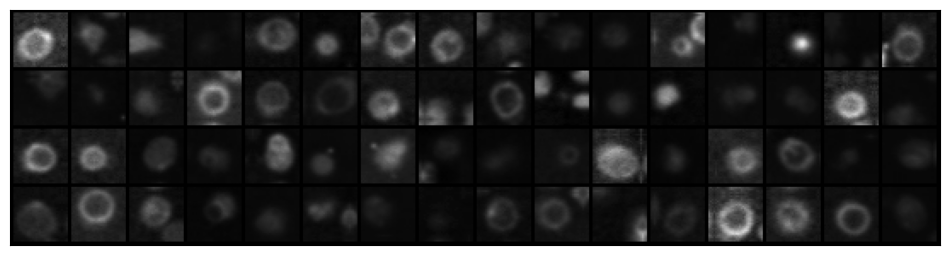

In [21]:
# Show traing batch
for images, labels in train_dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=16).permute(1, 2, 0))
    break

### Define variabels for model

In [22]:
input_size = 32*32*3
output_size = len(dataset.classes)

### Define the basclass

In [23]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        

### Define accuracy metric

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Extends the base class to create Resnet9 yeast model

In [25]:
# Define block in resnet
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet9_yeast_model(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

### Initialize the model

In [26]:
model = ResNet9_yeast_model(3, 2)
model.to(device)

ResNet9_yeast_model(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReL

### Evaluation function

In [27]:
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, max_lr, model, train_dl, val_dl, grad_clip=None, weight_decay=0, opt_func=torch.optim.Adam):
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    policy = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    history = []
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            policy.step()
            
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


### Train the model

In [28]:
torch.mps.empty_cache()
torch.mps.synchronize()
history = fit(num_epochs, max_lr, model, train_dl, val_dl, grad_clip, weight_decay, opt_func)

Epoch [0], train_loss: 0.8867, val_loss: 0.9358, val_acc: 0.4417
Epoch [1], train_loss: 0.2308, val_loss: 1.1359, val_acc: 0.4417
Epoch [2], train_loss: 0.1516, val_loss: 0.5851, val_acc: 0.6000
Epoch [3], train_loss: 0.0893, val_loss: 1.3564, val_acc: 0.5583
Epoch [4], train_loss: 0.0816, val_loss: 2.0950, val_acc: 0.5583
Epoch [5], train_loss: 0.0549, val_loss: 1.6583, val_acc: 0.5917
Epoch [6], train_loss: 0.1258, val_loss: 0.2458, val_acc: 0.9000
Epoch [7], train_loss: 0.0694, val_loss: 0.1784, val_acc: 0.9333
Epoch [8], train_loss: 0.1143, val_loss: 0.0729, val_acc: 0.9583
Epoch [9], train_loss: 0.0943, val_loss: 0.0772, val_acc: 0.9583
Epoch [10], train_loss: 0.0672, val_loss: 0.1863, val_acc: 0.9333
Epoch [11], train_loss: 0.1253, val_loss: 0.5672, val_acc: 0.8917
Epoch [12], train_loss: 0.1168, val_loss: 0.8845, val_acc: 0.7333
Epoch [13], train_loss: 0.1049, val_loss: 0.6251, val_acc: 0.8333
Epoch [14], train_loss: 0.0685, val_loss: 0.7646, val_acc: 0.7167
Epoch [15], train_lo

### Test agians test data

In [29]:
# Evaluate the model on the test set
result = evaluate(model, test_dl)
result

{'val_loss': 0.0016353549435734749, 'val_acc': 1.0}

### Test the model with test data

Result from test data:  {'val_loss': 0.0014626821503043175, 'val_acc': 1.0}


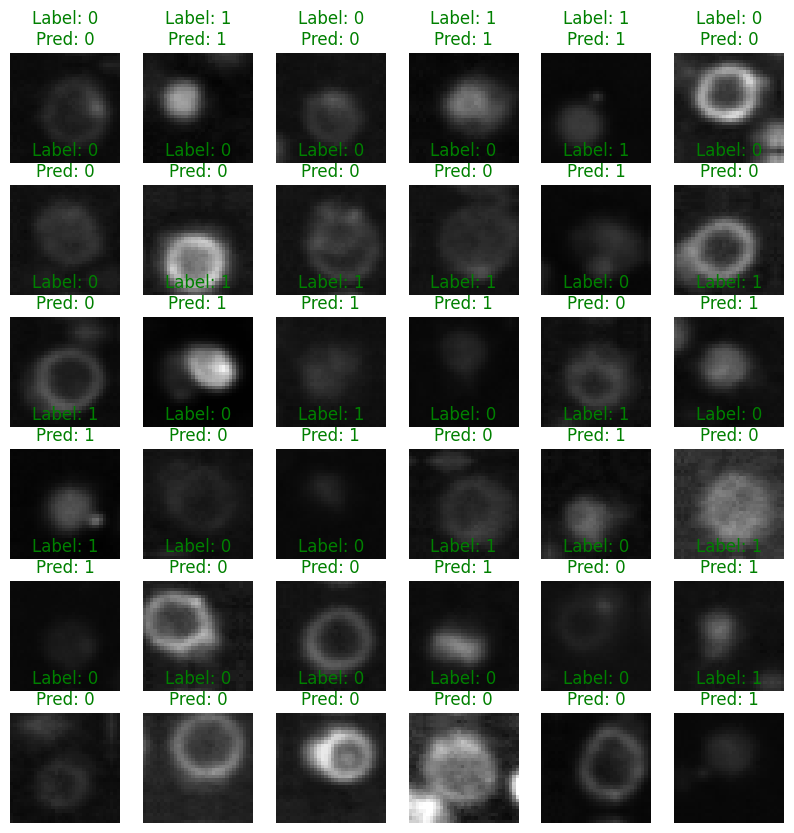

In [30]:
    
# Assuming evaluate function and model are defined elsewhere
print("Result from test data: ", evaluate(model, test_dl))

def display_images(images, labels, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(36):
        plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        # change the color of the title depending on the prediction
        plt.title(f"Label: {labels[i]}\nPred: {predictions[i]}", color=("green" if labels[i]==predictions[i].item() else "red"))
        plt.axis('off')
    plt.show()

# Get a batch of test data
test_images, test_labels = next(iter(train_dl))

# Move the batch to the same device as model and calculate predictions
test_images, test_labels = test_images.to(device), test_labels.to(device)
with torch.no_grad():
    model.eval()
    outputs = model(test_images)
    _, preds = torch.max(outputs, 1)

# Assuming 'device' is the device you're using (CPU or CUDA)
test_images, test_labels, preds = test_images.cpu(), test_labels.cpu(), preds.cpu()

# Display a 6x6 grid of test images with true and predicted labels
display_images(test_images, test_labels, preds)

### Plots

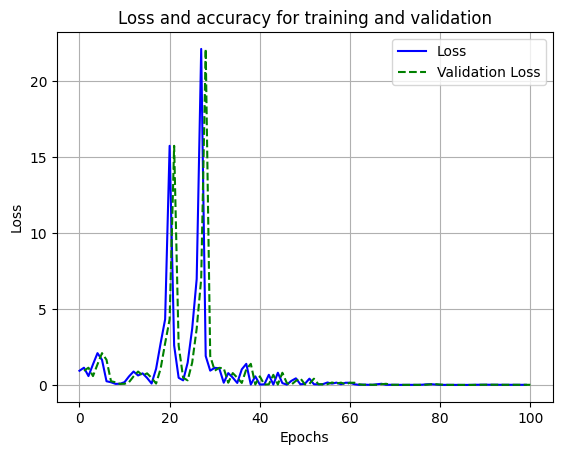

In [34]:
# Plot loss- and validation loss for each epoch
tn = np.arange(1, len(history) + 1)
fig, ax1 = plt.subplots()
ax1.plot([x['val_loss'] for x in history], 'b', label="Loss")
ax1.plot(tn, [x['val_loss'] for x in history], '--', color='g', label="Validation Loss")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

plt.grid()
plt.title('Loss and accuracy for training and validation')
plot = plt.show()



In [33]:
# Define the key for the model based on the hyperparameters and time
from datetime import date
import time
key = "R-CNN" + batch_size.__str__() + "_" + num_epochs.__str__() + "_" + opt_func.__name__ + "_" + date.today().__str__() + "_" + device.type +  "_" + time.strftime("%H_%M_%S")
print("Model key: ", key)

# ask if the user want to save the graph using input to /Users/bastiangraver/Desktop/6.Semester/BA Project/Model_Runs
# current folder /Users/bastiangraver/Desktop/6.Semester/BA Project/Python
save = input("Do you want to save the graph? (y/n): ")
if save == "y":
    plt.savefig(f"Model_Runs/{key}.png")
    print("Graph saved as: ", key + ".png")

# ask if the user wants to save the model using input
save = input("Do you want to save the model? (y/n): ")
if save == "y":
    torch.save(model.state_dict(), f"models/{key}.pth")
    print("Model saved as: ", key + ".pth")
else:
    print("Model not saved")

Model key:  CNN64_100_Adam_2024-05-14_mps_15_59_33
Graph saved as:  CNN64_100_Adam_2024-05-14_mps_15_59_33.png
Model saved as:  CNN64_100_Adam_2024-05-14_mps_15_59_33.pth


<Figure size 640x480 with 0 Axes>